# VAE学習用データセット統計分析

このノートブックは、3D椎体骨折検出プロジェクトで使用するVAE学習用データセットの統計を可視化します。

## 分析項目
1. データセット全体の統計（サンプル数、患者数、椎体部位分布）
2. 弱ラベルと正解マスクの統計（全ボクセルに対する割合）
3. 椎体部位ごとの統計（サンプル数、骨折含有率）
4. 可視化グラフ（棒グラフ、円グラフ、ヒストグラム、箱ひげ図）

In [1]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import ipynbname

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# seabornスタイル設定
sns.set_style("whitegrid")
sns.set_palette("husl")

## 1. データパスの設定

In [2]:
import ipynbname
from pathlib import Path

# Notebook のパス取得
nb_cur_file = Path(ipynbname.path())  # ← Path に変換する
PROJECT_ROOT = nb_cur_file.parents[3]
DATA_DIR = PROJECT_ROOT / "data/3d_data"

print("Notebook:", nb_cur_file)
print("Project Root:", PROJECT_ROOT)
print("Data Directory:", DATA_DIR)

# 各データセットのパス
VAE_TRAIN_DIR = DATA_DIR / 'train_vae'
DET_VOL_DIR = DATA_DIR / 'train_det' / 'vol'
WEAK_LABEL_DIR = DATA_DIR / 'train_det' / 'mask_weak_label'
GT_LABEL_DIR = DATA_DIR / 'train_det' / 'mask_gt_label'

# パスが存在するか確認
for path in [VAE_TRAIN_DIR, DET_VOL_DIR, WEAK_LABEL_DIR, GT_LABEL_DIR]:
    path = Path(path)  # 念のため Path に変換
    assert path.exists(), f"Path does not exist: {path}"

print("All paths are valid!")


Notebook: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/claude/notebook/VAE/dataset_statistics.ipynb
Project Root: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka
Data Directory: /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/data/3d_data
All paths are valid!


## 2. データセット全体の統計

In [3]:
# ファイルリストを取得
vae_files = sorted(list(VAE_TRAIN_DIR.glob('*.npy')))
det_vol_files = sorted(list(DET_VOL_DIR.glob('*.npy')))
weak_files = sorted(list(WEAK_LABEL_DIR.glob('*.npy')))
gt_files = sorted(list(GT_LABEL_DIR.glob('*.npy')))

print("="*60)
print("データセット全体の統計")
print("="*60)
print(f"VAE学習用データ数（正常椎体のみ）: {len(vae_files)}")
print(f"骨折検出用データ数（全椎体）: {len(det_vol_files)}")
print(f"弱ラベル数: {len(weak_files)}")
print(f"正解マスク数: {len(gt_files)}")
print()

データセット全体の統計
VAE学習用データ数（正常椎体のみ）: 279
骨折検出用データ数（全椎体）: 514
弱ラベル数: 514
正解マスク数: 514



In [4]:
# ファイル名から患者IDと椎体部位を抽出
def parse_filename(filepath):
    """
    ファイル名から患者IDと椎体部位を抽出
    例: vol_1003_L5.npy -> patient_id='1003', vertebra='L5'
    """
    filename = filepath.stem  # 拡張子を除いたファイル名
    parts = filename.split('_')
    
    # プレフィックス（vol, weak, gt）を除外
    if parts[0] in ['vol', 'weak', 'gt']:
        patient_id = parts[1]
        vertebra = parts[2]
    else:
        patient_id = parts[0]
        vertebra = parts[1]
    
    return patient_id, vertebra

# 全データの患者IDと椎体部位を抽出
det_data_info = [parse_filename(f) for f in det_vol_files]
vae_data_info = [parse_filename(f) for f in vae_files]

# 患者ID一覧
all_patient_ids = set([info[0] for info in det_data_info])
vae_patient_ids = set([info[0] for info in vae_data_info])

print(f"全患者数: {len(all_patient_ids)}")
print(f"VAE学習データに含まれる患者数: {len(vae_patient_ids)}")
print(f"\n患者ID一覧: {sorted(all_patient_ids)}")
print()

全患者数: 38
VAE学習データに含まれる患者数: 38

患者ID一覧: ['1003', '1010', '1012', '1015', '1016', '1017', '1021', '1025', '1027', '1030', '1035', '1038', '1039', '1043', '1045', '1046', '1047', '1049', '1051', '1052', '1054', '1055', '1059', '1060', '1061', '1062', '1067', '1069', '1070', '1073', '1074', '1075', '1077', '1079', '1080', '1082', '1083', '1084']



## 3. 椎体部位ごとのサンプル数分布

In [5]:
# 椎体部位ごとのカウント
det_vertebrae_count = Counter([info[1] for info in det_data_info])
vae_vertebrae_count = Counter([info[1] for info in vae_data_info])

# 椎体部位の順序を定義（T4からL5まで）
vertebra_order = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 
                  'L1', 'L2', 'L3', 'L4', 'L5']

print("="*60)
print("椎体部位ごとのサンプル数")
print("="*60)
print(f"{'部位':<6} {'全データ':>10} {'VAE用(正常)':>15}")
print("-"*60)

for vert in vertebra_order:
    det_count = det_vertebrae_count.get(vert, 0)
    vae_count = vae_vertebrae_count.get(vert, 0)
    print(f"{vert:<6} {det_count:>10} {vae_count:>15}")
    
print("="*60)
print(f"{'合計':<6} {sum(det_vertebrae_count.values()):>10} {sum(vae_vertebrae_count.values()):>15}")
print()

椎体部位ごとのサンプル数
部位           全データ        VAE用(正常)
------------------------------------------------------------
T4             33              29
T5             33              27
T6             34              27
T7             36              29
T8             37              29
T9             37              25
T10            38              20
T11            38              11
T12            38              10
L1             38               7
L2             38               6
L3             38              11
L4             38              22
L5             38              26
合計            514             279



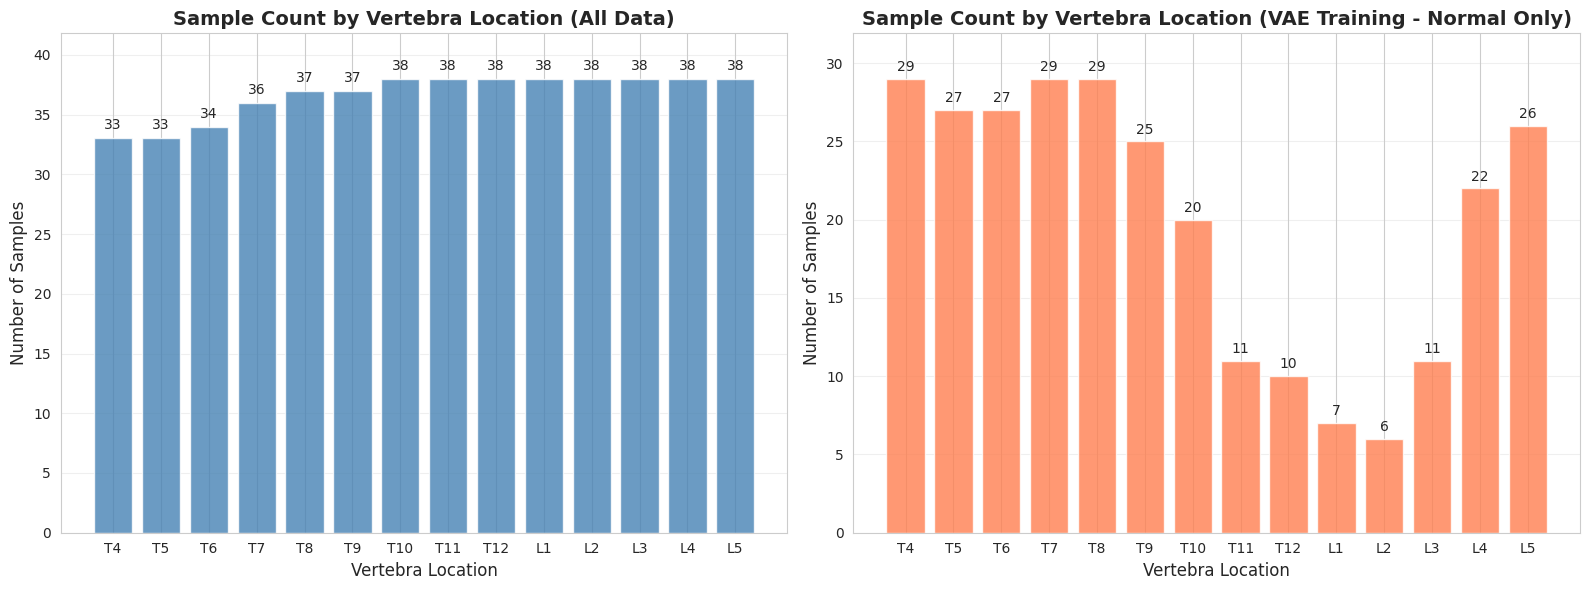

In [6]:
# 椎体部位ごとのサンプル数を棒グラフで可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 全データの棒グラフ
det_counts = [det_vertebrae_count.get(v, 0) for v in vertebra_order]
ax1.bar(vertebra_order, det_counts, color='steelblue', alpha=0.8)
ax1.set_xlabel('Vertebra Location', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Sample Count by Vertebra Location (All Data)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, max(det_counts) * 1.1)

# 各バーの上に数値を表示
for i, v in enumerate(det_counts):
    ax1.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

# VAE用データの棒グラフ
vae_counts = [vae_vertebrae_count.get(v, 0) for v in vertebra_order]
ax2.bar(vertebra_order, vae_counts, color='coral', alpha=0.8)
ax2.set_xlabel('Vertebra Location', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Sample Count by Vertebra Location (VAE Training - Normal Only)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(vae_counts) * 1.1)

# 各バーの上に数値を表示
for i, v in enumerate(vae_counts):
    if v > 0:
        ax2.text(i, v + 0.3, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 4. 正常データと骨折データの割合

正常データと骨折データの内訳
正常データ: 279 (54.3%)
骨折含有データ: 235 (45.7%)
合計: 514



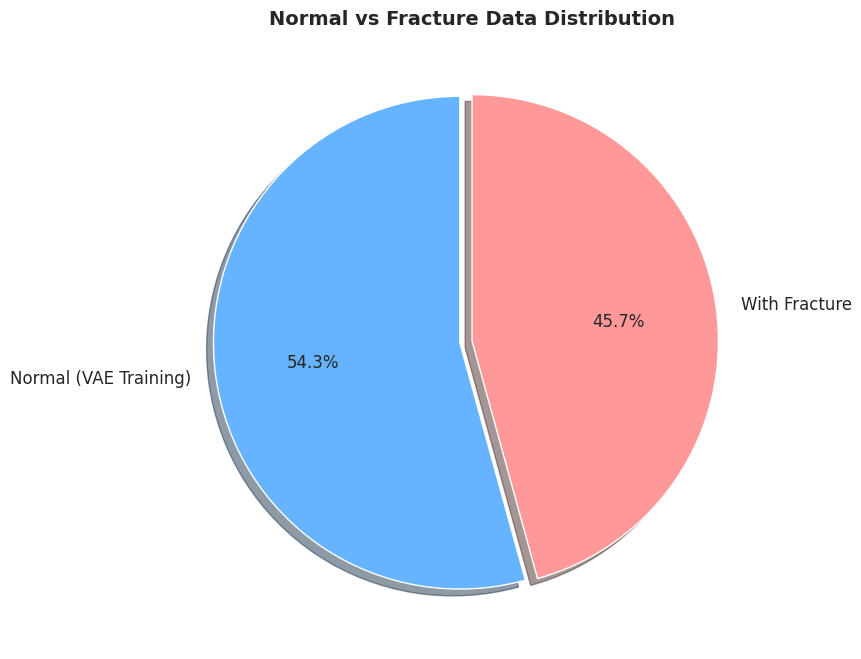

In [7]:
# VAE用データ（正常）と骨折データの数
normal_count = len(vae_files)
all_count = len(det_vol_files)
fracture_count = all_count - normal_count

print("="*60)
print("正常データと骨折データの内訳")
print("="*60)
print(f"正常データ: {normal_count} ({normal_count/all_count*100:.1f}%)")
print(f"骨折含有データ: {fracture_count} ({fracture_count/all_count*100:.1f}%)")
print(f"合計: {all_count}")
print()

# 円グラフで可視化
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels = ['Normal (VAE Training)', 'With Fracture']
sizes = [normal_count, fracture_count]
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)  # 正常データを少し外側に

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 12})
ax.set_title('Normal vs Fracture Data Distribution', fontsize=14, fontweight='bold')
plt.show()

## 5. 弱ラベルと正解マスクの統計分析

In [8]:
# 弱ラベルと正解マスクの統計を収集
print("弱ラベルと正解マスクの統計を計算中...")

weak_stats = []
gt_stats = []

for weak_file, gt_file in zip(weak_files, gt_files):
    # データ読み込み
    weak_mask = np.load(weak_file)
    gt_mask = np.load(gt_file)
    
    # ファイル名から情報抽出
    patient_id, vertebra = parse_filename(weak_file)
    
    # 全ボクセル数
    total_voxels = weak_mask.size
    
    # 陽性ボクセル数と割合
    weak_positive = np.sum(weak_mask > 0)
    weak_ratio = weak_positive / total_voxels * 100
    
    gt_positive = np.sum(gt_mask > 0)
    gt_ratio = gt_positive / total_voxels * 100
    
    # 統計情報を保存
    weak_stats.append({
        'patient_id': patient_id,
        'vertebra': vertebra,
        'positive_voxels': weak_positive,
        'total_voxels': total_voxels,
        'ratio': weak_ratio
    })
    
    gt_stats.append({
        'patient_id': patient_id,
        'vertebra': vertebra,
        'positive_voxels': gt_positive,
        'total_voxels': total_voxels,
        'ratio': gt_ratio
    })

# DataFrameに変換
weak_df = pd.DataFrame(weak_stats)
gt_df = pd.DataFrame(gt_stats)

print("完了!\n")

弱ラベルと正解マスクの統計を計算中...
完了!



In [9]:
# 基本統計量の表示
print("="*60)
print("弱ラベル（Weak Label）の統計")
print("="*60)
print(weak_df['ratio'].describe())
print()

print("="*60)
print("正解マスク（Ground Truth）の統計")
print("="*60)
print(gt_df['ratio'].describe())
print()

弱ラベル（Weak Label）の統計
count    514.000000
mean       1.480382
std        2.796002
min        0.000000
25%        0.000000
50%        0.000000
75%        2.123117
max       18.270493
Name: ratio, dtype: float64

正解マスク（Ground Truth）の統計
count    514.000000
mean       0.047460
std        0.081020
min        0.000000
25%        0.000000
50%        0.000000
75%        0.069463
max        0.356388
Name: ratio, dtype: float64



In [10]:
# 骨折あり/なしのサンプルを分離
weak_with_fracture = weak_df[weak_df['positive_voxels'] > 0]
weak_without_fracture = weak_df[weak_df['positive_voxels'] == 0]

gt_with_fracture = gt_df[gt_df['positive_voxels'] > 0]
gt_without_fracture = gt_df[gt_df['positive_voxels'] == 0]

print("="*60)
print("骨折の有無による分類")
print("="*60)
print(f"弱ラベル - 骨折あり: {len(weak_with_fracture)}, 骨折なし: {len(weak_without_fracture)}")
print(f"正解マスク - 骨折あり: {len(gt_with_fracture)}, 骨折なし: {len(gt_without_fracture)}")
print()

if len(weak_with_fracture) > 0:
    print("="*60)
    print("骨折ありサンプルの弱ラベル統計")
    print("="*60)
    print(weak_with_fracture['ratio'].describe())
    print()

if len(gt_with_fracture) > 0:
    print("="*60)
    print("骨折ありサンプルの正解マスク統計")
    print("="*60)
    print(gt_with_fracture['ratio'].describe())
    print()

骨折の有無による分類
弱ラベル - 骨折あり: 235, 骨折なし: 279
正解マスク - 骨折あり: 235, 骨折なし: 279

骨折ありサンプルの弱ラベル統計
count    235.000000
mean       3.237942
std        3.379858
min        0.001144
25%        0.739336
50%        2.541447
75%        4.721069
max       18.270493
Name: ratio, dtype: float64

骨折ありサンプルの正解マスク統計
count    235.000000
mean       0.103805
std        0.092286
min        0.000620
25%        0.022197
50%        0.086641
75%        0.160384
max        0.356388
Name: ratio, dtype: float64



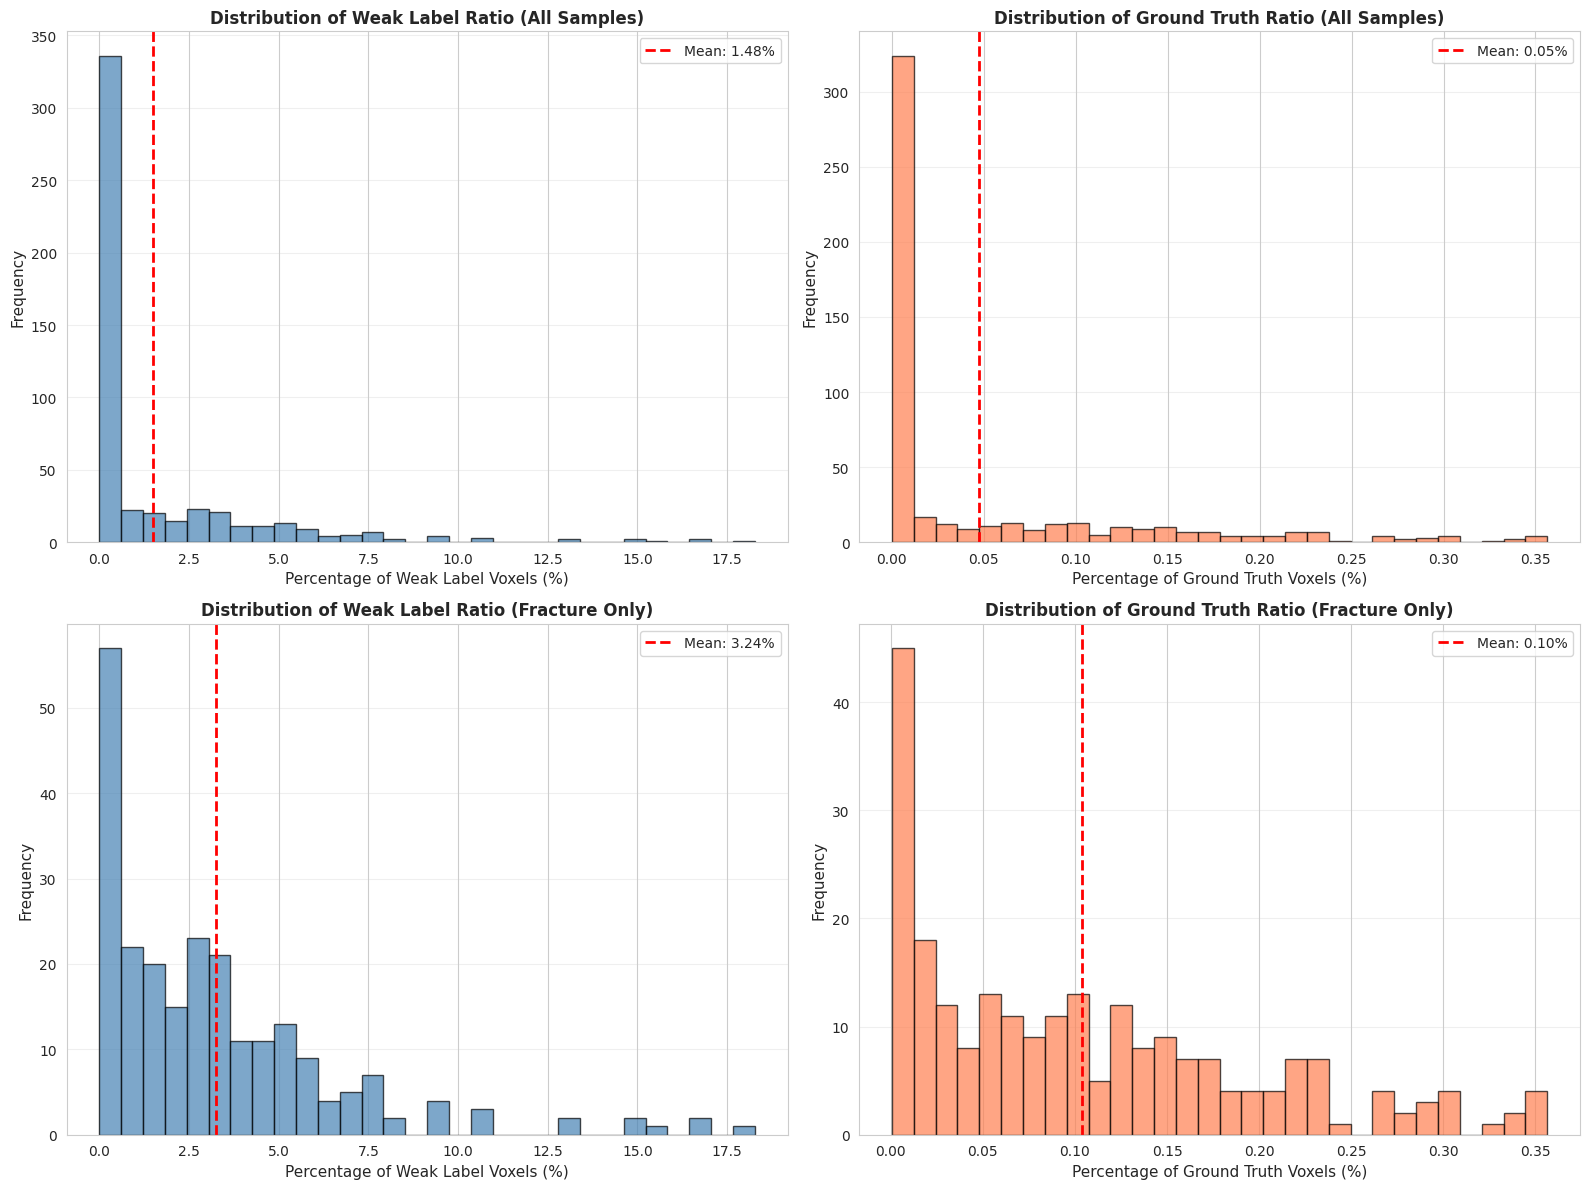

In [11]:
# ヒストグラムで可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 弱ラベルのヒストグラム（全データ）
ax1 = axes[0, 0]
ax1.hist(weak_df['ratio'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Percentage of Weak Label Voxels (%)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Weak Label Ratio (All Samples)', fontsize=12, fontweight='bold')
ax1.axvline(weak_df['ratio'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {weak_df["ratio"].mean():.2f}%')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 正解マスクのヒストグラム（全データ）
ax2 = axes[0, 1]
ax2.hist(gt_df['ratio'], bins=30, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Percentage of Ground Truth Voxels (%)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Ground Truth Ratio (All Samples)', fontsize=12, fontweight='bold')
ax2.axvline(gt_df['ratio'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {gt_df["ratio"].mean():.2f}%')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 弱ラベルのヒストグラム（骨折ありのみ）
ax3 = axes[1, 0]
if len(weak_with_fracture) > 0:
    ax3.hist(weak_with_fracture['ratio'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Percentage of Weak Label Voxels (%)', fontsize=11)
    ax3.set_ylabel('Frequency', fontsize=11)
    ax3.set_title('Distribution of Weak Label Ratio (Fracture Only)', fontsize=12, fontweight='bold')
    ax3.axvline(weak_with_fracture['ratio'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {weak_with_fracture["ratio"].mean():.2f}%')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No fracture data', ha='center', va='center', transform=ax3.transAxes, fontsize=14)

# 正解マスクのヒストグラム（骨折ありのみ）
ax4 = axes[1, 1]
if len(gt_with_fracture) > 0:
    ax4.hist(gt_with_fracture['ratio'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Percentage of Ground Truth Voxels (%)', fontsize=11)
    ax4.set_ylabel('Frequency', fontsize=11)
    ax4.set_title('Distribution of Ground Truth Ratio (Fracture Only)', fontsize=12, fontweight='bold')
    ax4.axvline(gt_with_fracture['ratio'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {gt_with_fracture["ratio"].mean():.2f}%')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No fracture data', ha='center', va='center', transform=ax4.transAxes, fontsize=14)

plt.tight_layout()
plt.show()

## 6. 椎体部位ごとの骨折統計

In [12]:
# 椎体部位ごとの骨折含有率を計算
vertebra_fracture_stats = defaultdict(lambda: {'total': 0, 'with_fracture': 0})

for _, row in gt_df.iterrows():
    vert = row['vertebra']
    vertebra_fracture_stats[vert]['total'] += 1
    if row['positive_voxels'] > 0:
        vertebra_fracture_stats[vert]['with_fracture'] += 1

# 骨折含有率を計算
print("="*60)
print("椎体部位ごとの骨折含有率")
print("="*60)
print(f"{'部位':<6} {'全サンプル':>12} {'骨折あり':>12} {'骨折率(%)':>12}")
print("-"*60)

for vert in vertebra_order:
    stats = vertebra_fracture_stats[vert]
    total = stats['total']
    with_frac = stats['with_fracture']
    frac_rate = (with_frac / total * 100) if total > 0 else 0
    print(f"{vert:<6} {total:>12} {with_frac:>12} {frac_rate:>12.1f}")

print()

椎体部位ごとの骨折含有率
部位            全サンプル         骨折あり       骨折率(%)
------------------------------------------------------------
T4               33            4         12.1
T5               33            6         18.2
T6               34            7         20.6
T7               36            7         19.4
T8               37            8         21.6
T9               37           12         32.4
T10              38           18         47.4
T11              38           27         71.1
T12              38           28         73.7
L1               38           31         81.6
L2               38           32         84.2
L3               38           27         71.1
L4               38           16         42.1
L5               38           12         31.6



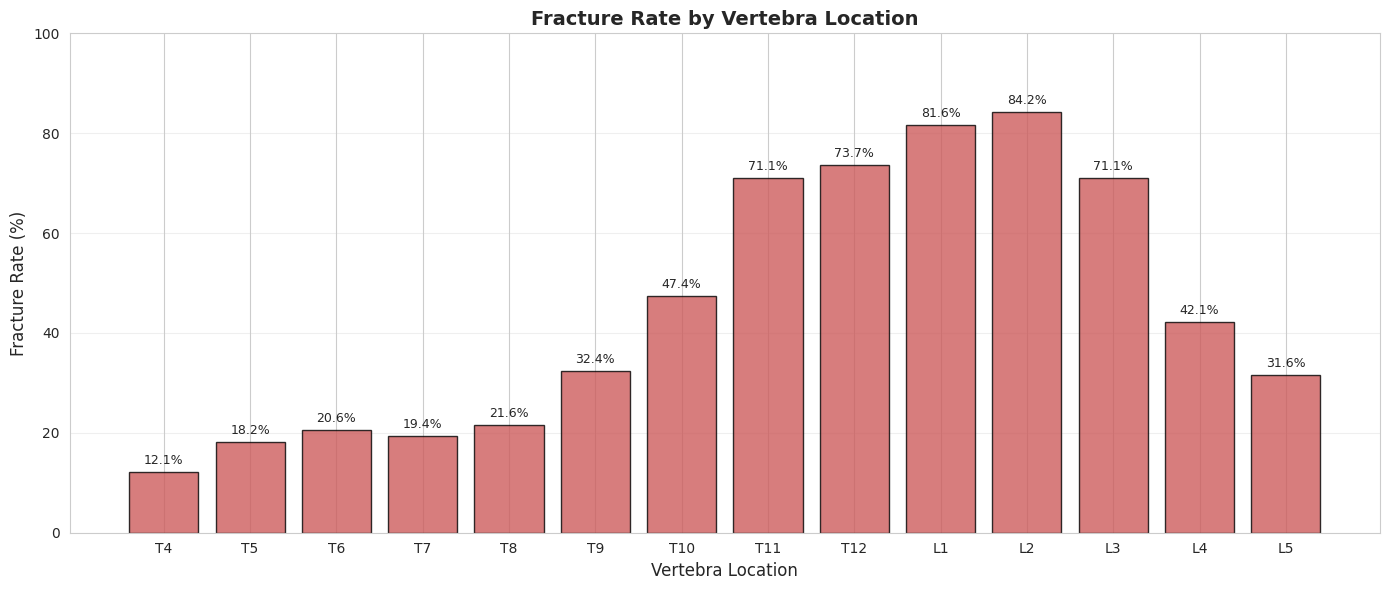

In [13]:
# 椎体部位ごとの骨折率を棒グラフで可視化
fracture_rates = []
for vert in vertebra_order:
    stats = vertebra_fracture_stats[vert]
    total = stats['total']
    with_frac = stats['with_fracture']
    frac_rate = (with_frac / total * 100) if total > 0 else 0
    fracture_rates.append(frac_rate)

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(vertebra_order, fracture_rates, color='indianred', alpha=0.8, edgecolor='black')
ax.set_xlabel('Vertebra Location', fontsize=12)
ax.set_ylabel('Fracture Rate (%)', fontsize=12)
ax.set_title('Fracture Rate by Vertebra Location', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 100)

# 各バーの上に数値を表示
for i, (bar, rate) in enumerate(zip(bars, fracture_rates)):
    if rate > 0:
        ax.text(bar.get_x() + bar.get_width()/2, rate + 1, f'{rate:.1f}%', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 7. 椎体部位ごとの弱ラベル・正解マスクサイズ分布

/tmp/ipykernel_4139518/589295841.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(weak_data_for_box, labels=labels_for_box, patch_artist=True,
/tmp/ipykernel_4139518/589295841.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(gt_data_for_box, labels=labels_for_box, patch_artist=True,


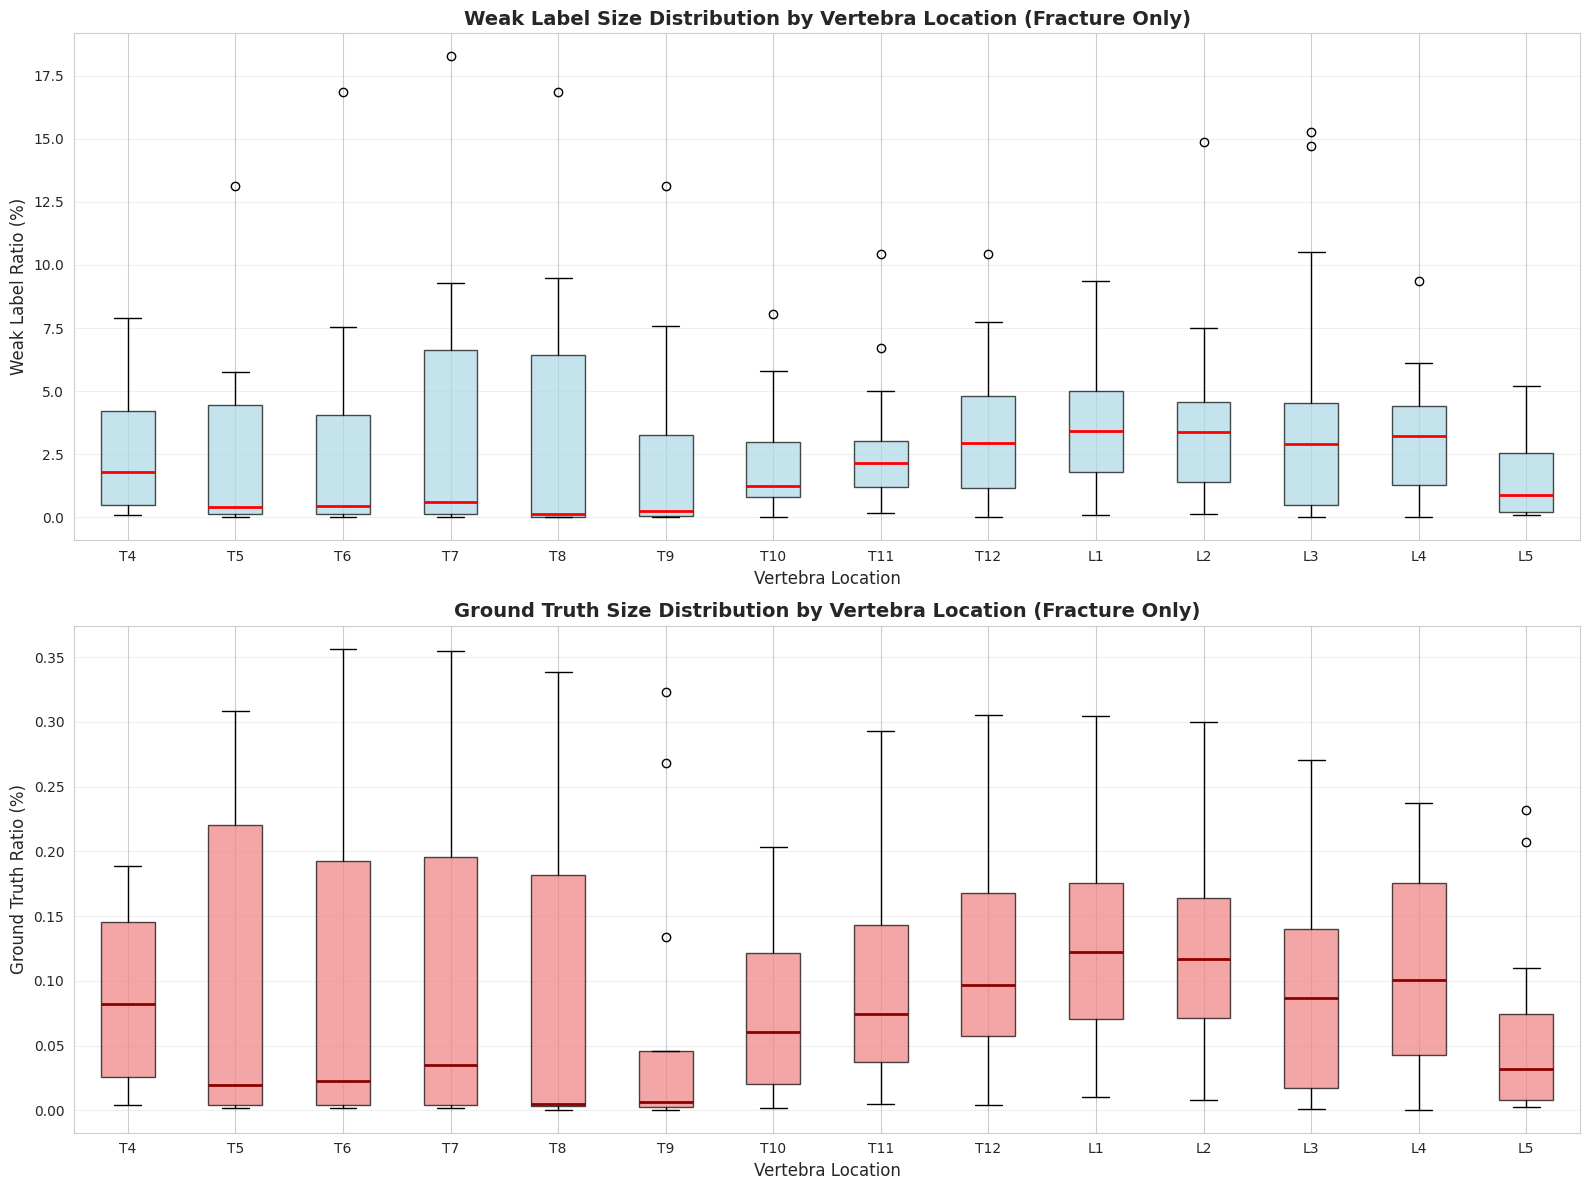

In [14]:
# 骨折ありサンプルのみで部位ごとの統計を計算
weak_with_frac_by_vert = weak_with_fracture.groupby('vertebra')['ratio'].apply(list).to_dict()
gt_with_frac_by_vert = gt_with_fracture.groupby('vertebra')['ratio'].apply(list).to_dict()

# 箱ひげ図用にデータを準備
weak_data_for_box = []
gt_data_for_box = []
labels_for_box = []

for vert in vertebra_order:
    if vert in weak_with_frac_by_vert and len(weak_with_frac_by_vert[vert]) > 0:
        weak_data_for_box.append(weak_with_frac_by_vert[vert])
        gt_data_for_box.append(gt_with_frac_by_vert.get(vert, []))
        labels_for_box.append(vert)

# 箱ひげ図で可視化
if len(labels_for_box) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # 弱ラベルの箱ひげ図
    bp1 = ax1.boxplot(weak_data_for_box, labels=labels_for_box, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2))
    ax1.set_xlabel('Vertebra Location', fontsize=12)
    ax1.set_ylabel('Weak Label Ratio (%)', fontsize=12)
    ax1.set_title('Weak Label Size Distribution by Vertebra Location (Fracture Only)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # 正解マスクの箱ひげ図
    bp2 = ax2.boxplot(gt_data_for_box, labels=labels_for_box, patch_artist=True,
                       boxprops=dict(facecolor='lightcoral', alpha=0.7),
                       medianprops=dict(color='darkred', linewidth=2))
    ax2.set_xlabel('Vertebra Location', fontsize=12)
    ax2.set_ylabel('Ground Truth Ratio (%)', fontsize=12)
    ax2.set_title('Ground Truth Size Distribution by Vertebra Location (Fracture Only)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("骨折ありサンプルが見つかりませんでした。")

## 8. 弱ラベルと正解マスクの比較

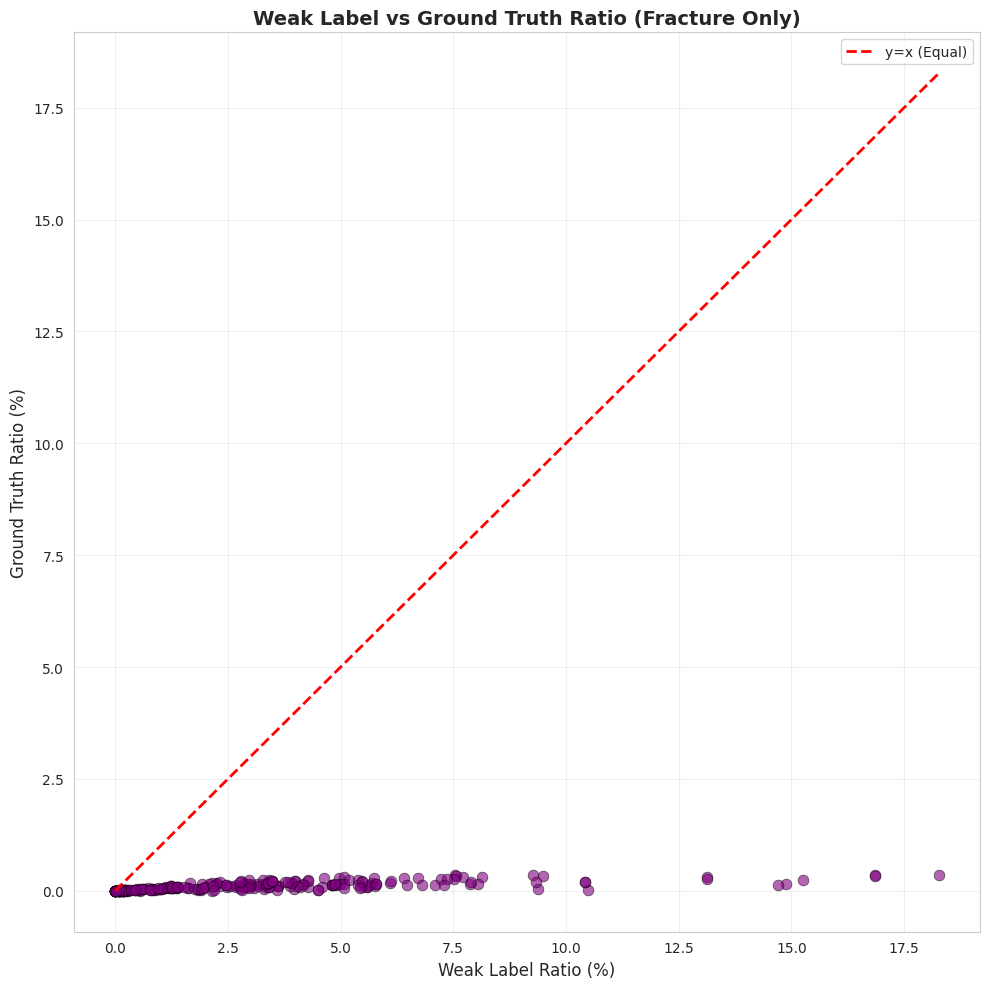


弱ラベルと正解マスクの相関係数: 0.734
平均比率 - 弱ラベル: 3.24%, 正解マスク: 0.10%
弱ラベル/正解マスク の平均比: 38.26


In [15]:
# 弱ラベルと正解マスクの比率を散布図で比較（骨折ありのみ）
if len(gt_with_fracture) > 0 and len(weak_with_fracture) > 0:
    # データをマージ
    comparison_df = pd.merge(
        weak_with_fracture[['patient_id', 'vertebra', 'ratio']],
        gt_with_fracture[['patient_id', 'vertebra', 'ratio']],
        on=['patient_id', 'vertebra'],
        suffixes=('_weak', '_gt')
    )
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 散布図
    scatter = ax.scatter(comparison_df['ratio_weak'], comparison_df['ratio_gt'], 
                         alpha=0.6, s=60, c='purple', edgecolors='black', linewidth=0.5)
    
    # 対角線（y=x）を引く
    max_val = max(comparison_df['ratio_weak'].max(), comparison_df['ratio_gt'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y=x (Equal)')
    
    ax.set_xlabel('Weak Label Ratio (%)', fontsize=12)
    ax.set_ylabel('Ground Truth Ratio (%)', fontsize=12)
    ax.set_title('Weak Label vs Ground Truth Ratio (Fracture Only)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 相関係数を計算
    correlation = comparison_df['ratio_weak'].corr(comparison_df['ratio_gt'])
    print(f"\n弱ラベルと正解マスクの相関係数: {correlation:.3f}")
    print(f"平均比率 - 弱ラベル: {comparison_df['ratio_weak'].mean():.2f}%, 正解マスク: {comparison_df['ratio_gt'].mean():.2f}%")
    print(f"弱ラベル/正解マスク の平均比: {(comparison_df['ratio_weak'] / comparison_df['ratio_gt']).mean():.2f}")
else:
    print("骨折ありサンプルが見つかりませんでした。")

## 9. 骨折ボリュームに対する弱ラベル・正解マスクのボクセル比率分析

骨折ありサンプルにおいて、弱ラベル領域と正解マスク領域の相対的な大きさを分析します。  
具体的には、各サンプルの正解マスク（骨折領域）のボクセル数を基準として、弱ラベルがその何倍の大きさかを計算します。

## 10. 患者ごとの椎体分析

In [19]:
# 患者ごとの正常・骨折椎体の情報を集計
patient_vertebrae_info = defaultdict(lambda: {'normal': [], 'fracture': []})

# 正常椎体
for patient_id, vertebra in vae_data_info:
    patient_vertebrae_info[patient_id]['normal'].append(vertebra)

# 全椎体データから骨折椎体を特定
det_data_set = set(det_data_info)
vae_data_set = set(vae_data_info)
fracture_data_info = list(det_data_set - vae_data_set)

for patient_id, vertebra in fracture_data_info:
    patient_vertebrae_info[patient_id]['fracture'].append(vertebra)

# 椎体部位の順序
vertebra_order_map = {v: i for i, v in enumerate(vertebra_order)}

# 結果を表示
print("="*95)
print("患者ごとの正常・骨折椎体数")
print("="*95)
print(f"{'患者ID':<8} | {'正常椎体数':<12} | {'骨折椎体数':<12} | {'正常椎体リスト':<40} | {'骨折椎体リスト'}")
print("-"*95)

for patient_id in sorted(all_patient_ids):
    info = patient_vertebrae_info[patient_id]
    
    # 椎体リストをソート
    normal_vertebrae = sorted(info['normal'], key=lambda v: vertebra_order_map.get(v, 99))
    fracture_vertebrae = sorted(info['fracture'], key=lambda v: vertebra_order_map.get(v, 99))
    
    normal_count = len(normal_vertebrae)
    fracture_count = len(fracture_vertebrae)
    
    print(f"{patient_id:<8} | {normal_count:^12} | {fracture_count:^12} | {', '.join(normal_vertebrae):<40} | {', '.join(fracture_vertebrae)}")

print("="*95)

患者ごとの正常・骨折椎体数
患者ID     | 正常椎体数        | 骨折椎体数        | 正常椎体リスト                                  | 骨折椎体リスト
-----------------------------------------------------------------------------------------------
1003     |      8       |      6       | T4, T5, T6, T7, T8, T9, L4, L5           | T10, T11, T12, L1, L2, L3
1010     |      9       |      5       | T4, T5, T6, T7, T8, T9, T10, T11, L5     | T12, L1, L2, L3, L4
1012     |      9       |      5       | T4, T5, T6, T7, T8, T9, T10, L4, L5      | T11, T12, L1, L2, L3
1015     |      9       |      5       | T4, T5, T6, T7, T8, T9, T10, L4, L5      | T11, T12, L1, L2, L3
1016     |      9       |      5       | T4, T5, T6, T7, T8, T9, L3, L4, L5       | T10, T11, T12, L1, L2
1017     |      9       |      5       | T4, T5, T6, T7, T8, T9, T10, T11, T12    | L1, L2, L3, L4, L5
1021     |      7       |      7       | T4, T5, T6, T7, T8, T9, T10              | T11, T12, L1, L2, L3, L4, L5
1025     |      8       |      6       | T4, T5, T6,

## 11. サマリーレポート

In [18]:
print("="*80)
print(" "*25 + "VAEデータセット統計サマリー")
print("="*80)
print()
print("【1. データセット全体】")
print(f"  - 全椎体データ数: {len(det_vol_files)}")
print(f"  - VAE学習用データ数（正常のみ）: {len(vae_files)}")
print(f"  - 骨折含有データ数: {len(det_vol_files) - len(vae_files)}")
print(f"  - 患者数: {len(all_patient_ids)}")
print(f"  - 椎体部位: {vertebra_order[0]}〜{vertebra_order[-1]} ({len(vertebra_order)}種類)")
print()

print("【2. 正常/骨折データの割合】")
print(f"  - 正常データ: {normal_count} ({normal_count/all_count*100:.1f}%)")
print(f"  - 骨折含有データ: {fracture_count} ({fracture_count/all_count*100:.1f}%)")
print()

if len(weak_with_fracture) > 0:
    print("【3. 弱ラベル統計（骨折ありサンプルのみ）】")
    print(f"  - サンプル数: {len(weak_with_fracture)}")
    print(f"  - 平均ボクセル割合: {weak_with_fracture['ratio'].mean():.3f}%")
    print(f"  - 中央値: {weak_with_fracture['ratio'].median():.3f}%")
    print(f"  - 最小値: {weak_with_fracture['ratio'].min():.3f}%")
    print(f"  - 最大値: {weak_with_fracture['ratio'].max():.3f}%")
    print()

if len(gt_with_fracture) > 0:
    print("【4. 正解マスク統計（骨折ありサンプルのみ）】")
    print(f"  - サンプル数: {len(gt_with_fracture)}")
    print(f"  - 平均ボクセル割合: {gt_with_fracture['ratio'].mean():.3f}%")
    print(f"  - 中央値: {gt_with_fracture['ratio'].median():.3f}%")
    print(f"  - 最小値: {gt_with_fracture['ratio'].min():.3f}%")
    print(f"  - 最大値: {gt_with_fracture['ratio'].max():.3f}%")
    print()

print("【5. 椎体部位ごとの最も骨折率が高い部位】")
max_frac_idx = fracture_rates.index(max(fracture_rates))
max_frac_vert = vertebra_order[max_frac_idx]
max_frac_rate = fracture_rates[max_frac_idx]
print(f"  - 最高骨折率: {max_frac_vert} ({max_frac_rate:.1f}%)")
print()

print("="*80)
print(" "*30 + "分析完了")
print("="*80)

                         VAEデータセット統計サマリー

【1. データセット全体】
  - 全椎体データ数: 514
  - VAE学習用データ数（正常のみ）: 279
  - 骨折含有データ数: 235
  - 患者数: 38
  - 椎体部位: T4〜L5 (14種類)

【2. 正常/骨折データの割合】
  - 正常データ: 279 (54.3%)
  - 骨折含有データ: 235 (45.7%)

【3. 弱ラベル統計（骨折ありサンプルのみ）】
  - サンプル数: 235
  - 平均ボクセル割合: 3.238%
  - 中央値: 2.541%
  - 最小値: 0.001%
  - 最大値: 18.270%

【4. 正解マスク統計（骨折ありサンプルのみ）】
  - サンプル数: 235
  - 平均ボクセル割合: 0.104%
  - 中央値: 0.087%
  - 最小値: 0.001%
  - 最大値: 0.356%

【5. 椎体部位ごとの最も骨折率が高い部位】
  - 最高骨折率: L2 (84.2%)

                              分析完了
